<a href="https://colab.research.google.com/github/hazieon/Exoplanet-Detection/blob/dev/Kepler_Exoplanet(Project_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

In [ ]:
#file_path='/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv'

#file_path='/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv'
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/kepler_dataset.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
#df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv')
# df=pd.read_csv('/content/drive/MyDrive/KeplerExoplanet/TESS_data.csv')

#wecan directly use column names with header=0
#7803 data points 39 feature columns
#print few rows of starting default 5

df = pd.read_csv(
    '/content/drive/MyDrive/KeplerExoplanet/K2_Planets_and_candidates_NASA.csv',
    comment='#'
)

# Strip column names of leading/trailing spaces
df.columns = df.columns.str.strip()

# List of numeric columns to convert
numeric_cols = ['pl_rade', 'pl_eqt', 'pl_orbper', 'pl_insol', 'st_teff', 'st_rad']

# Convert each column to float
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Verify conversion
print(df[numeric_cols].dtypes)

df=df.loc[:4000]


print(df.head(5))

pl_rade      float64
pl_eqt       float64
pl_orbper    float64
pl_insol     float64
st_teff      float64
st_rad       float64
dtype: object
             pl_name        hostname  default_flag disposition  \
0        BD+20 594 b       BD+20 594             0   CONFIRMED   
1        BD+20 594 b       BD+20 594             0   CONFIRMED   
2        BD+20 594 b       BD+20 594             1   CONFIRMED   
3  EPIC 201111557.01  EPIC 201111557             1   CANDIDATE   
4  EPIC 201111557.01  EPIC 201111557             0   CANDIDATE   

             disp_refname  sy_snum  sy_pnum discoverymethod  disc_year  \
0    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
1    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
2    Espinoza et al. 2016      1.0      1.0         Transit     2016.0   
3  Livingston et al. 2018      1.0      0.0         Transit     2018.0   
4  Livingston et al. 2018      1.0      0.0         Transit     2018.0   

  disc_facility  .

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Binary target: 1 = CONFIRMED, 0 = non-planets
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Separate confirmed and non-confirmed planets
confirmed = df[df['ConfirmedExoplanet'] == 1]
non_planet = df[df['ConfirmedExoplanet'] == 0]

# Undersample the majority class ('CONFIRMED') to match the number of minority class samples ('non-planet')
confirmed_downsampled = resample(confirmed,
                                  replace=False,
                                  n_samples=len(non_planet), # Sample size is now the number of non-planets
                                  random_state=42)

# Combine and shuffle
df_balanced = pd.concat([confirmed_downsampled, non_planet]).sample(frac=1, random_state=42)

# Select numeric features
numeric_cols = df_balanced.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df_balanced[feature_cols]
y = df_balanced['ConfirmedExoplanet']

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalization
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

Training set distribution:
 ConfirmedExoplanet
1    1267
0    1266
Name: count, dtype: int64
Testing set distribution:
 ConfirmedExoplanet
0    423
1    422
Name: count, dtype: int64


In [ ]:
# @title
# #first we split then we normalize to prevent data leakage and increase accuracy
# l=['ExoplanetCandidate','ExoplanetConfirmed']
# X=df.drop(l,axis=1)  # Features (excluding the target column)
# y=df['ExoplanetCandidate']  # Target variable
# #Splitting
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=4000/7000, random_state=42,
#                                                     stratify=y # ensures class balance in train/test
# )

# Binary target: 1 = CONFIRMED (CONFIRMED exoplanets only), 0 = non-planets (CANDIDATE, FALSE POSITIVE, REFUTED, etc.)
df['ConfirmedExoplanet'] = df['disposition'].apply(lambda x: 1 if x == 'CONFIRMED' else 0)

# Select numeric columns as features
numeric_cols = df.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ConfirmedExoplanet']]
X = df[feature_cols]
y = df['ConfirmedExoplanet']


# #Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,
                                                    stratify=y # ensures class balance in train/test
 )

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())


#Normalizatiom
scaler=StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)




Training set distribution:
 ConfirmedExoplanet
1    1734
0    1266
Name: count, dtype: int64
Testing set distribution:
 ConfirmedExoplanet
1    578
0    423
Name: count, dtype: int64


Accuracy: 0.9905325443786982
Confusion Matrix:
 [[415   8]
 [  0 422]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       423
           1       0.98      1.00      0.99       422

    accuracy                           0.99       845
   macro avg       0.99      0.99      0.99       845
weighted avg       0.99      0.99      0.99       845



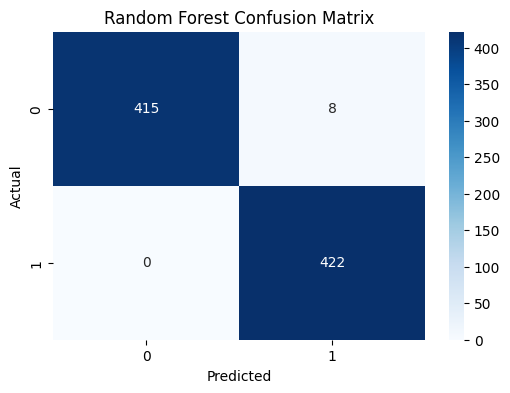

In [ ]:
# Random Forest Classifier - Classical machine learning analysis
#
# Instantiate Random Forest with various anti-overfitting tweaks
# Initially the model returned a suspicious 100% accuracy, so added more parameters

# sy_pnum is the dominant feature, so it is excluded to highlight its importance for categorisation and as to not to overshadow the others
# sy_pnum_df = feat_imp_df[feat_imp_df['Feature'] == 'sy_pnum']
# other_features_df = feat_imp_df[feat_imp_df['Feature'] != 'sy_pnum'].head(15)  # top 15 excluding_]()


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Instantiate Random Forest with anti-overfitting tweaks
rf = RandomForestClassifier(
    n_estimators=100,       # number of trees
    max_depth=5,            # limit tree depth
    min_samples_split=10,   # minimum samples to split a node
    max_features='sqrt',    # only consider sqrt(total_features) per split
    random_state=42
)

# Fit the model
rf.fit(X_train_normalized, y_train)

# Predict
y_pred = rf.predict(X_test_normalized)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


In [ ]:
#Building Neural Network Model
model=Sequential()

# Add input layer
model.add(Dense(units=16,activation='sigmoid', input_shape=(X_train_normalized.shape[1],)))

# Add hidden layers
model.add(Dense(units=8,activation='sigmoid'))
model.add(Dense(units=4,activation='sigmoid'))

# Add the output layer
model.add(Dense(units=1,activation='sigmoid'))  # For binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 16)             │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,409 (5.50 KB)

 Trainable params: 1,409 (5.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5055 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4902 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4807 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5133 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4938 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4853 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4807 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5060 - loss: nan - val_accuracy: 0.4990 - val_loss: nan
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s

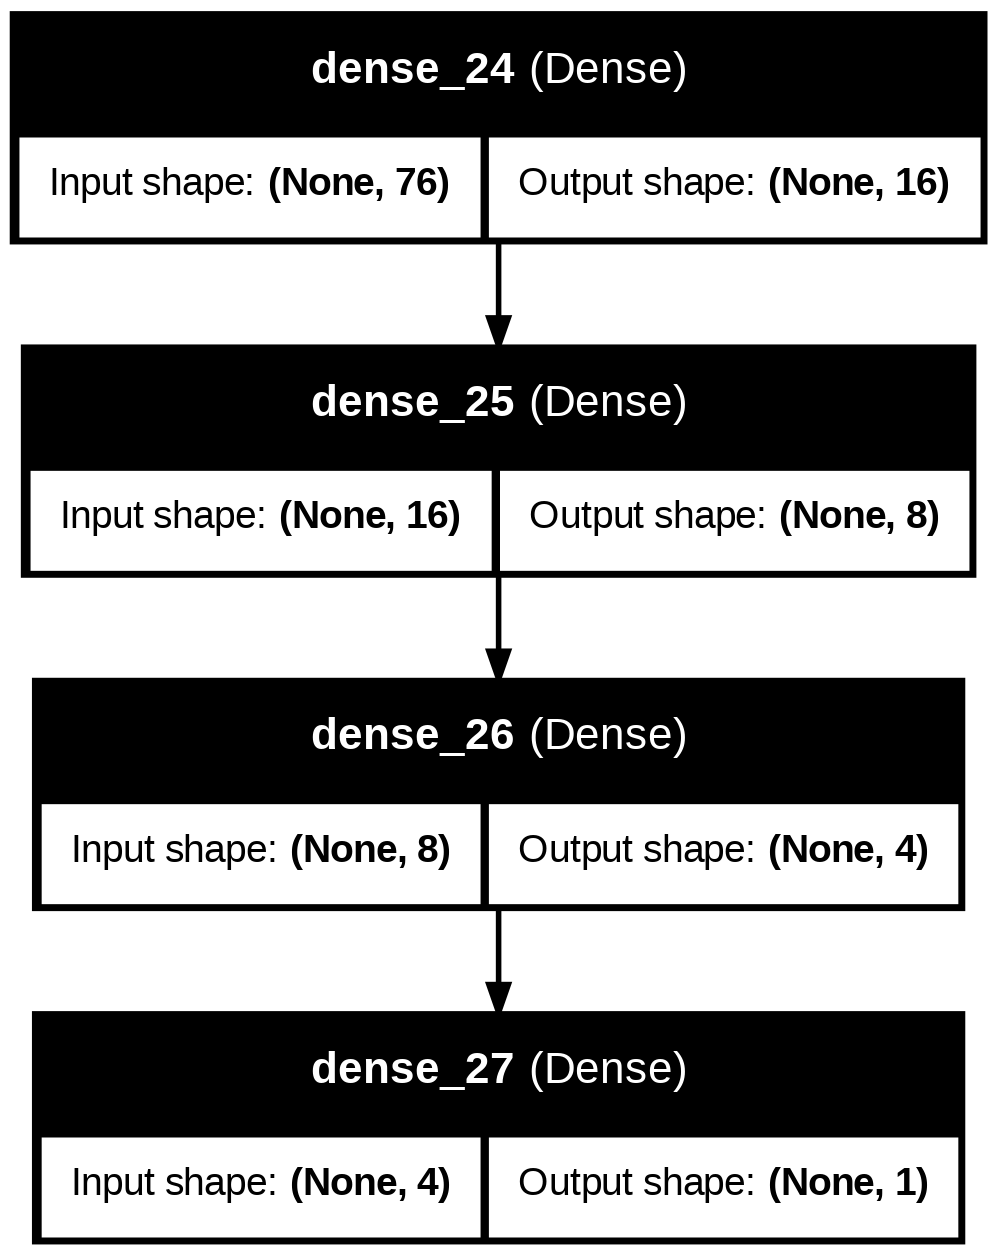

In [ ]:
# Train the model
model.fit(X_train_normalized, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

from tensorflow.keras.utils import plot_model

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))
